In [26]:
import import_ipynb
import data_preprocessing
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, f1_score, confusion_matrix, roc_curve, auc
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import shap

- remove seasonablity
- drop nans (if pre-processing from seasonality)
- others?
- try to understand autocorrelation in initial features
- 

- get residuals for each timestep
- cluster the residuals
- adaptive thresholding (exponential moving average could be good)
- use windowing to be more robust to what average values should be. 
- feature engineering -> add month, add important interaction terms, 

- rule based detection (set threshold based on training data)
- require multiple anomalies in a row to happen in order to flag is an anomaly. 

In [27]:
# training data
u4_train_equil_turbine = data_preprocessing.u4_train_equil_turbine
u4_train_equil_pump = data_preprocessing.u4_train_equil_pump
u5_train_equil_turbine = data_preprocessing.u5_train_equil_turbine
u5_train_equil_pump = data_preprocessing.u5_train_equil_pump
u6_train_equil_turbine = data_preprocessing.u6_train_equil_turbine
u6_train_equil_pump = data_preprocessing.u6_train_equil_pump

# synethetic test sets
u5_s01_equil_turbine = data_preprocessing.u5_s01_equil_turbine
u5_s01_equil_pump = data_preprocessing.u5_s01_equil_pump
u5_s02_equil_turbine = data_preprocessing.u5_s02_equil_turbine
u5_s02_equil_pump = data_preprocessing.u5_s02_equil_pump
u6_s01_equil_turbine = data_preprocessing.u6_s01_equil_turbine
u6_s01_equil_pump = data_preprocessing.u6_s01_equil_pump
u6_s02_equil_turbine = data_preprocessing.u6_s02_equil_turbine
u6_s02_equil_pump = data_preprocessing.u6_s02_equil_pump

# real test sets
u4_test_equil_turbine = data_preprocessing.u4_test_equil_turbine
u4_test_equil_pump = data_preprocessing.u4_test_equil_pump
u5_test_equil_turbine = data_preprocessing.u5_test_equil_turbine
u5_test_equil_pump = data_preprocessing.u5_test_equil_pump
u6_test_equil_turbine = data_preprocessing.u6_test_equil_turbine
u6_test_equil_pump = data_preprocessing.u6_test_equil_pump

In [28]:
# # training data
# u4_train_equil_turbine = josh_data_preprocessing.u4_train_equil_turbine
# u4_train_equil_pump = josh_data_preprocessing.u4_train_equil_pump
# u5_train_equil_turbine = josh_data_preprocessing.u5_train_equil_turbine
# u5_train_equil_pump = josh_data_preprocessing.u5_train_equil_pump
# u6_train_equil_turbine = josh_data_preprocessing.u6_train_equil_turbine
# u6_train_equil_pump = josh_data_preprocessing.u6_train_equil_pump

# # synethetic test sets
# u5_s01_equil_turbine = josh_data_preprocessing.u5_s01_equil_turbine
# u5_s01_equil_pump = josh_data_preprocessing.u5_s01_equil_pump
# u5_s02_equil_turbine = josh_data_preprocessing.u5_s02_equil_turbine
# u5_s02_equil_pump = josh_data_preprocessing.u5_s02_equil_pump
# u6_s01_equil_turbine = josh_data_preprocessing.u6_s01_equil_turbine
# u6_s01_equil_pump = josh_data_preprocessing.u6_s01_equil_pump
# u6_s02_equil_turbine = josh_data_preprocessing.u6_s02_equil_turbine
# u6_s02_equil_pump = josh_data_preprocessing.u6_s02_equil_pump

# # real test sets
# u4_test_equil_turbine = josh_data_preprocessing.u4_test_equil_turbine
# u4_test_equil_pump = josh_data_preprocessing.u4_test_equil_pump
# u5_test_equil_turbine = josh_data_preprocessing.u5_test_equil_turbine
# u5_test_equil_pump = josh_data_preprocessing.u5_test_equil_pump
# u6_test_equil_turbine = josh_data_preprocessing.u6_test_equil_turbine
# u6_test_equil_pump = josh_data_preprocessing.u6_test_equil_pump

In [29]:
# restart kernel/VScode until the ema features show up

u5_s01_equil_pump

,tot_activepower,ext_tmp,plant_tmp,charge,coupler_position,injector_01_opening,injector_02_opening,injector_03_opening,injector_04_opening,injector_05_opening,...,anomaly,minute,hour,day,month,year,dayofweek,dayofyear,is_weekend,injector_sum
2021-06-02 03:01:00+02:00,0.464175,-1.648222,-2.407136,0.031737,2.225175,0.0,-0.008824,0.0,-0.008231,-0.006712,...,0,-1.659452,-0.945088,-1.151728,-0.941566,0.0,-1.437847,-1.449848,-1.092906,-0.012595
2021-06-02 03:01:30+02:00,0.575518,-1.649248,-2.395595,0.077920,2.102579,0.0,-0.008824,0.0,-0.008231,-0.006712,...,0,-1.659452,-0.945088,-1.151728,-0.941566,0.0,-1.437847,-1.449848,-1.092906,-0.012595
2021-06-02 03:02:00+02:00,0.499891,-1.650274,-2.384054,0.036434,1.979983,0.0,-0.008824,0.0,-0.008231,-0.006712,...,0,-1.601396,-0.945088,-1.151728,-0.941566,0.0,-1.437847,-1.449848,-1.092906,-0.012595
2021-06-02 03:02:30+02:00,-0.127160,-1.651300,-2.372513,0.080509,1.857386,0.0,-0.008824,0.0,-0.008231,-0.006712,...,0,-1.601396,-0.945088,-1.151728,-0.941566,0.0,-1.437847,-1.449848,-1.092906,-0.012595
2021-06-02 03:03:00+02:00,-0.368755,-1.652326,-2.360972,-0.094250,1.734790,0.0,-0.008824,0.0,-0.008231,-0.006712,...,0,-1.543341,-0.945088,-1.151728,-0.941566,0.0,-1.437847,-1.449848,-1.092906,-0.012595
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-07-30 18:54:30+02:00,-0.129836,0.854294,2.491872,-0.124377,12.945039,0.0,-0.008824,0.0,-0.008231,-0.006712,...,0,1.417473,1.758590,2.270254,1.062060,0.0,-0.167246,2.125180,-1.092906,-0.012595
2021-07-30 18:55:00+02:00,-0.679229,0.859684,2.513162,-0.070131,14.396252,0.0,-0.008824,0.0,-0.008231,-0.006712,...,0,1.475529,1.758590,2.270254,1.062060,0.0,-0.167246,2.125180,-1.092906,-0.012595
2021-07-30 18:55:30+02:00,-1.531177,0.865075,2.602000,0.087530,15.847466,0.0,-0.008824,0.0,-0.008231,-0.006712,...,0,1.475529,1.758590,2.270254,1.062060,0.0,-0.167246,2.125180,-1.092906,-0.012595
2021-07-30 18:56:00+02:00,-0.789179,0.870465,2.690838,0.077920,17.298679,0.0,-0.008824,0.0,-0.008231,-0.006712,...,0,1.533584,1.758590,2.270254,1.062060,0.0,-0.167246,2.125180,-1.092906,-0.012595


In [30]:
# # need to add _ema_10 to all the features!

# features = [
#     'tot_activepower', 'charge', 'coupler_position', 'injector_01_opening', 'injector_02_opening',
#     'injector_03_opening', 'injector_04_opening', 'injector_05_opening', 'pump_calculated_flow',
#     'pump_pressure_diff', 'pump_rotspeed', 'turbine_pressure', 'turbine_rotspeed',
#     'water_primary_pump_01_opening', 'water_primary_pump_02_opening', 'timer_turbine_on_off', 
#     'minute', 'hour', 'day', 'month', 'year', 'dayofweek','dayofyear', 'is_weekend', 
#     'tot_activepower_ema_10', 'charge_ema_10', 'coupler_position_ema_10', 'injector_01_opening_ema_10', 'injector_02_opening_ema_10',
#     'injector_03_opening_ema_10', 'injector_04_opening_ema_10', 'injector_05_opening_ema_10', 'pump_calculated_flow_ema_10',
#     'pump_pressure_diff_ema_10', 'pump_rotspeed_ema_10', 'turbine_pressure_ema_10', 'turbine_rotspeed_ema_10',
#     'water_primary_pump_01_opening_ema_10', 'water_primary_pump_02_opening_ema_10', 'timer_turbine_on_off_ema_10', 
# ]

In [37]:
features = ['tot_activepower', 'ext_tmp', 'plant_tmp', 'coupler_position', 'pump_calculated_flow', 
            'pump_pressure_diff', 'pump_rotspeed', 'turbine_pressure', 'turbine_rotspeed', 
            'water_primary_pump_01_opening', 'scaled_injector_sum']

In [38]:
# Check if 'timer_turbine_on_off' is present; if not, exclude it from the feature list
features = [feature for feature in features if feature in u5_train_equil_pump.columns]

target = 'stat_magn_tmp_mean'

# Split the data into training and testing sets
train = u5_train_equil_pump[features]
y = u5_train_equil_pump[target]

KeyError: 'stat_magn_tmp_mean'

In [ ]:
# # Standardize the features before applying PCA
# scaler = StandardScaler()
# X_scaled = scaler.fit_transform(X)

# # Applying PCA
# pca = PCA(n_components=0.95)  # Keep 95% of variance
# X_pca = pca.fit_transform(X_scaled)

# print(f"Reduced number of features from {X.shape[1]} to {X_pca.shape[1]}")

In [ ]:
# import optuna
# from sklearn.ensemble import RandomForestRegressor
# from sklearn.metrics import mean_squared_error
# from sklearn.model_selection import train_test_split

# # Split the data into training and validation sets
# X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# # Define the objective function for Optuna
# # Define the objective function for Optuna
# def objective(trial):
#     # Define the hyperparameters to tune
#     # n_estimators = trial.suggest_int('n_estimators', 10, 100)
#     n_estimators = 10
#     max_depth = trial.suggest_int('max_depth', 3, 30)
#     min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
#     min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
#     max_features = trial.suggest_categorical('max_features', ['sqrt', 'log2', None])  # 'auto' removed

#     # Create the RandomForestRegressor with the suggested hyperparameters
#     model = RandomForestRegressor(
#         n_estimators=n_estimators,
#         max_depth=max_depth,
#         min_samples_split=min_samples_split,
#         min_samples_leaf=min_samples_leaf,
#         max_features=max_features,
#         random_state=42
#     )

#     # Train the model
#     model.fit(X_train, y_train)

#     # Predict on the validation set
#     y_val_pred = model.predict(X_val)

#     # Calculate RMSE as the evaluation metric
#     rmse = mean_squared_error(y_val, y_val_pred, squared=False)
#     return rmse


# # Create an Optuna study and optimize
# study = optuna.create_study(direction='minimize')
# study.optimize(objective, n_trials=50)  # Number of trials

# # Print the best hyperparameters
# print("Best hyperparameters:", study.best_params)

# # Train the final model with the best hyperparameters
# best_params = study.best_params

In [ ]:
final_model = RandomForestRegressor(
    n_estimators=10,
    # n_estimators=best_params['n_estimators'],
    # max_depth=best_params['max_depth'],
    # min_samples_split=best_params['min_samples_split'],
    # min_samples_leaf=best_params['min_samples_leaf'],
    # max_features=best_params['max_features'],
    random_state=42
)

final_model.fit(train, y)

# Predict on the test set
y_pred = final_model.predict(train)

residuals = y - y_pred

KeyboardInterrupt: 

In [ ]:
# # Evaluate the model
# mse = mean_squared_error(y_test, y_pred)
# rmse = np.sqrt(mse)
# r_squared = r2_score(y_test, y_pred)


# print(f'Mean Squared Error: {mse}')
# print(f'Root Mean Squared Error: {rmse}')
# print(f"R squared : {r_squared}")

In [ ]:
# plt.figure(figsize=(12, 6))
# sns.histplot(u5_s01_equil_pump["anomaly"], kde=False, color='blue', bins=2)
# plt.title('Distribution of anomalies')
# plt.xlabel('Residuals')
# plt.ylabel('Frequency')
# plt.show()

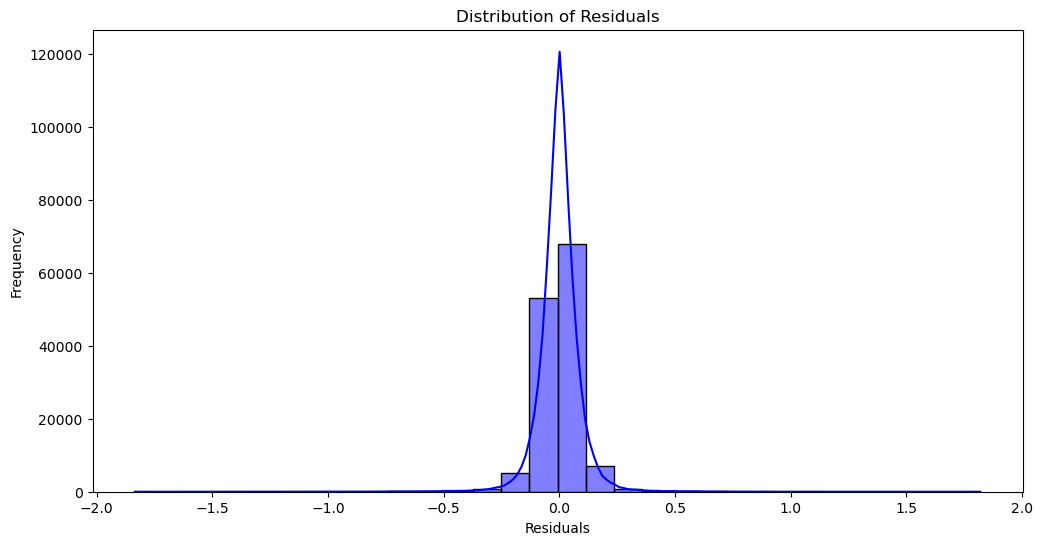

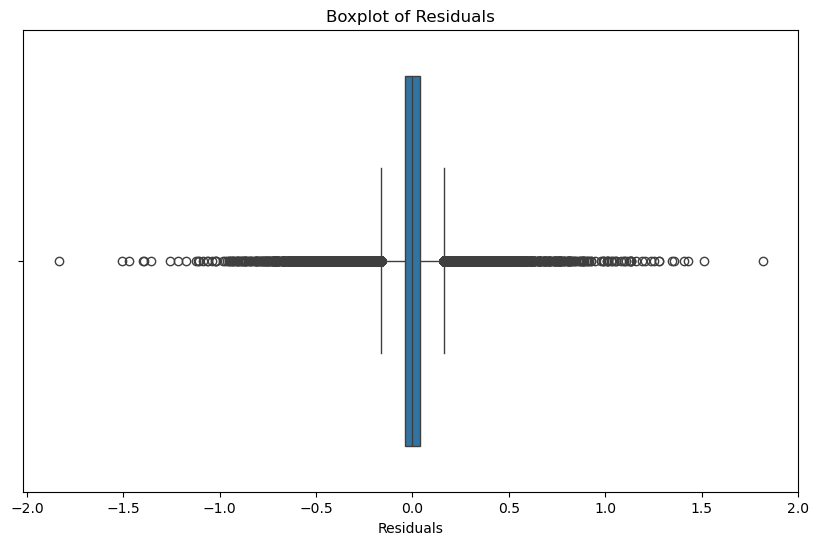

In [ ]:
plt.figure(figsize=(12, 6))
sns.histplot(residuals, kde=True, color='blue', bins=30)
plt.title('Distribution of Residuals')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()

# Optionally, also plot a boxplot to see outliers
plt.figure(figsize=(10, 6))
sns.boxplot(x=residuals)
plt.title('Boxplot of Residuals')
plt.xlabel('Residuals')
plt.show()

In [ ]:
# Basic statistical measures
mean_residual = np.mean(residuals)
std_residual = np.std(residuals)
max_residual = np.max(residuals)
min_residual = np.min(residuals)

print(f"Mean of Residuals: {mean_residual}")
print(f"Standard Deviation of Residuals: {std_residual}")
print(f"Max Residual: {max_residual}")
print(f"Min Residual: {min_residual}")


# Example threshold at 3 standard deviations from the mean
threshold = mean_residual + 4 * std_residual
print(f"Anomaly Threshold: {threshold}")

Mean of Residuals: 0.00020850688306464966
Standard Deviation of Residuals: 0.09302104606147933
Max Residual: 1.8194385919579128
Min Residual: -1.8352529981602923
Anomaly Threshold: 0.372292691128982


In [ ]:
# plt.figure(figsize=(10, 6))
# plt.scatter(y_test, y_pred, alpha=0.5)
# plt.title('Actual vs Predicted Values')
# plt.xlabel('Actual Values')
# plt.ylabel('Predicted Values')
# plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)  # Diagonal line
# plt.show()

# # Plot the actual and predicted values over the test set
# plt.figure(figsize=(14, 7))
# plt.scatter(y_test.index, y_test)
# plt.scatter(y_test.index, y_pred)
# # plt.plot(y_test.index, y_test, label='Actual Values', color='blue', marker='o')
# # plt.plot(y_test.index, y_pred, label='Predicted Values', color='red', linestyle='--', marker='x')
# plt.title('Comparison of Actual and Predicted Values')
# plt.xlabel('Index')
# plt.ylabel('Stator Coil Temperature')
# plt.legend()
# plt.show()

In [ ]:
# Extracting the features and target from the synthetic test set
X_synthetic = u5_s01_equil_pump[features]

y_synthetic = u5_s01_equil_pump['stat_magn_tmp_mean']

# Predict using the trained model
y_pred_synthetic = final_model.predict(X_synthetic)

In [ ]:
# Evaluate the model performance on synthetic data
mse_synthetic = mean_squared_error(y_synthetic, y_pred_synthetic)
rmse_synthetic = np.sqrt(mse_synthetic)
r_squared_synthetic = r2_score(y_synthetic, y_pred_synthetic)

print(f'Mean Squared Error on Synthetic Data: {mse_synthetic}')
print(f'Root Mean Squared Error on Synthetic Data: {rmse_synthetic}')
print(f"R squared : {r_squared_synthetic}")

Mean Squared Error on Synthetic Data: 1.6057585391362212
Root Mean Squared Error on Synthetic Data: 1.2671852820863339
R squared : -0.6057585391362208


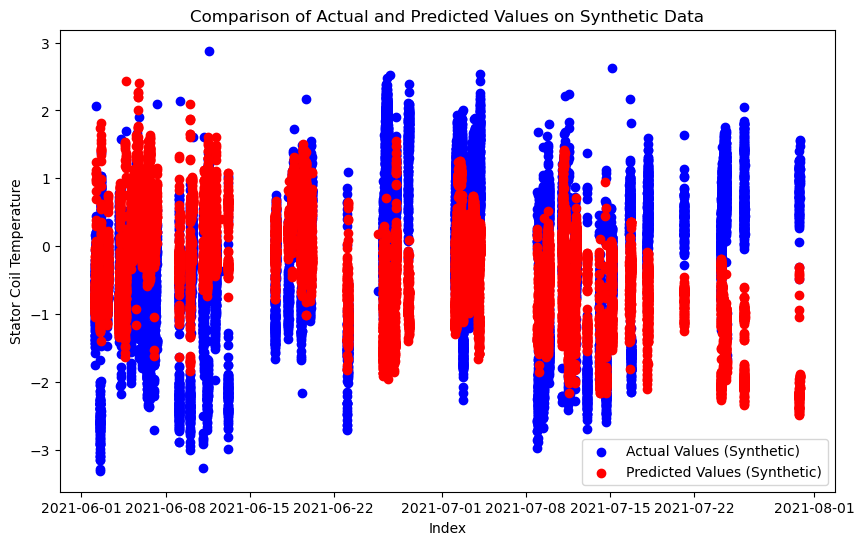

In [ ]:
# Visualizing the results with a scatter plot for actual vs predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_synthetic.index, y_synthetic, label='Actual Values (Synthetic)', color='blue')
plt.scatter(y_synthetic.index, y_pred_synthetic, label='Predicted Values (Synthetic)', color='red')
plt.title('Comparison of Actual and Predicted Values on Synthetic Data')
plt.xlabel('Index')
plt.ylabel('Stator Coil Temperature')
plt.legend()
plt.show()

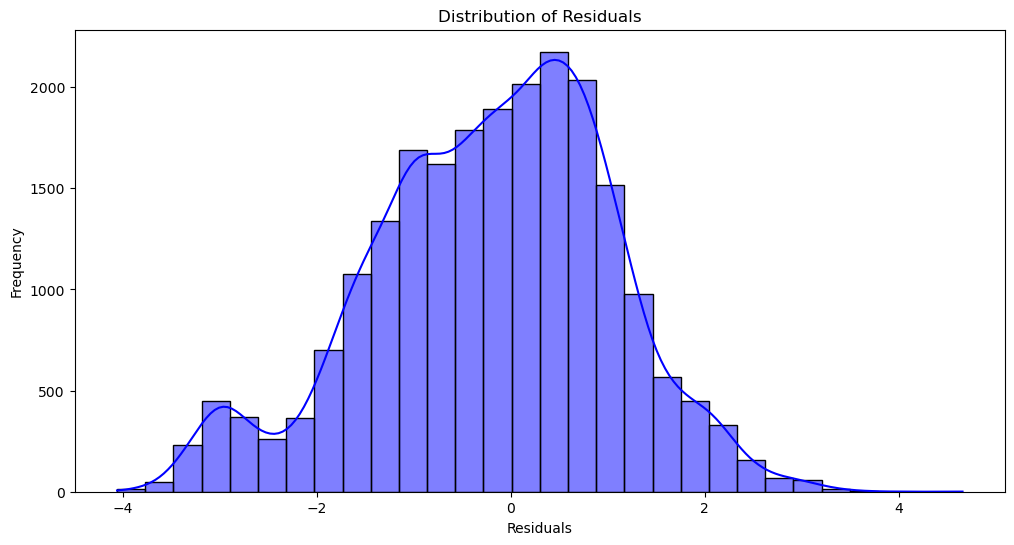

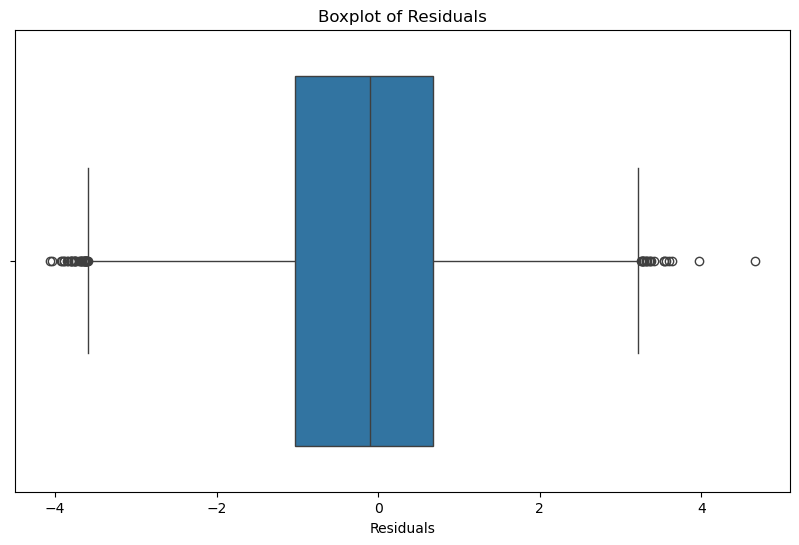

In [ ]:
residuals_synthetic = y_pred_synthetic - y_synthetic

plt.figure(figsize=(12, 6))
sns.histplot(residuals_synthetic, kde=True, color='blue', bins=30)
plt.title('Distribution of Residuals')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()

# Optionally, also plot a boxplot to see outliers
plt.figure(figsize=(10, 6))
sns.boxplot(x=residuals_synthetic)
plt.title('Boxplot of Residuals')
plt.xlabel('Residuals')
plt.show()

In [ ]:
# Step 3: Classify based on threshold
residuals_abs = np.abs(residuals_synthetic)

predicted_anomalies = (abs(residuals_synthetic) > threshold).astype(int)

# Step 4: Evaluate the model
true_anomalies = u5_s01_equil_pump['anomaly']

accuracy = accuracy_score(true_anomalies, predicted_anomalies)
f1 = f1_score(true_anomalies, predicted_anomalies)
conf_matrix = confusion_matrix(true_anomalies, predicted_anomalies)
fpr, tpr, thresholds = roc_curve(true_anomalies, residuals_abs)
roc_auc = auc(fpr, tpr)

print(f"Accuracy: {accuracy}")
print(f"F1 Score: {f1}")
print(f"auc score: {roc_auc}")
print(f"Confusion Matrix:\n{conf_matrix}")

Accuracy: 0.6921933420424343
F1 Score: 0.8164997180223971
auc score: 0.20089457961805585
Confusion Matrix:
[[  164  1956]
 [ 4877 15202]]


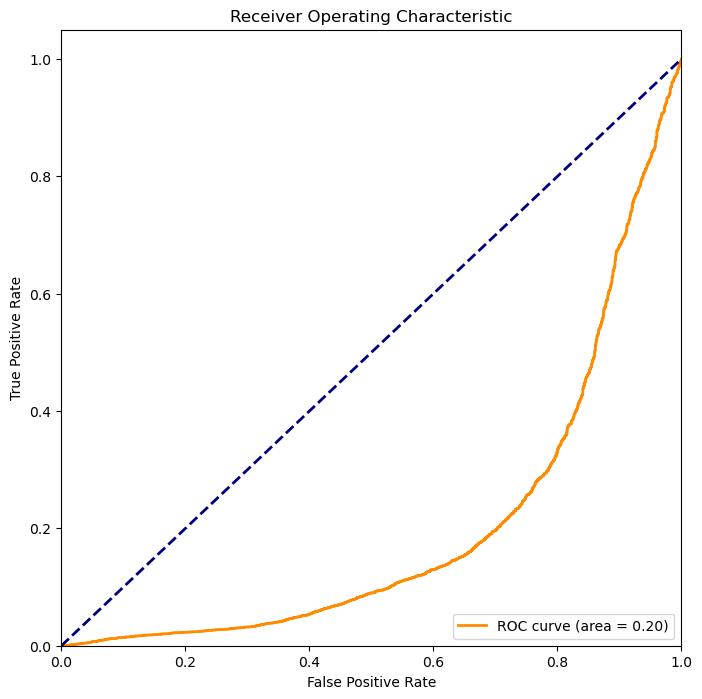

In [ ]:
# Compute ROC curve and ROC area
fpr, tpr, thresholds = roc_curve(true_anomalies, residuals_abs)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [ ]:
# # Create a SHAP explainer for the Random Forest model
# explainer = shap.Explainer(final_model, X)

# # Compute SHAP values
# shap_values = explainer(X)

# # Summary plot to visualize the impact of each feature
# shap.summary_plot(shap_values, X)

# # Force plot for a single prediction (e.g., first instance)
# shap.force_plot(explainer.expected_value, shap_values[0, :], X.iloc[0, :])

In [ ]:
X_sample = train.sample(n=100, random_state=42)  # Use only 100 samples

In [ ]:
explainer = shap.Explainer(final_model)
shap_values = explainer.shap_values(X_sample)

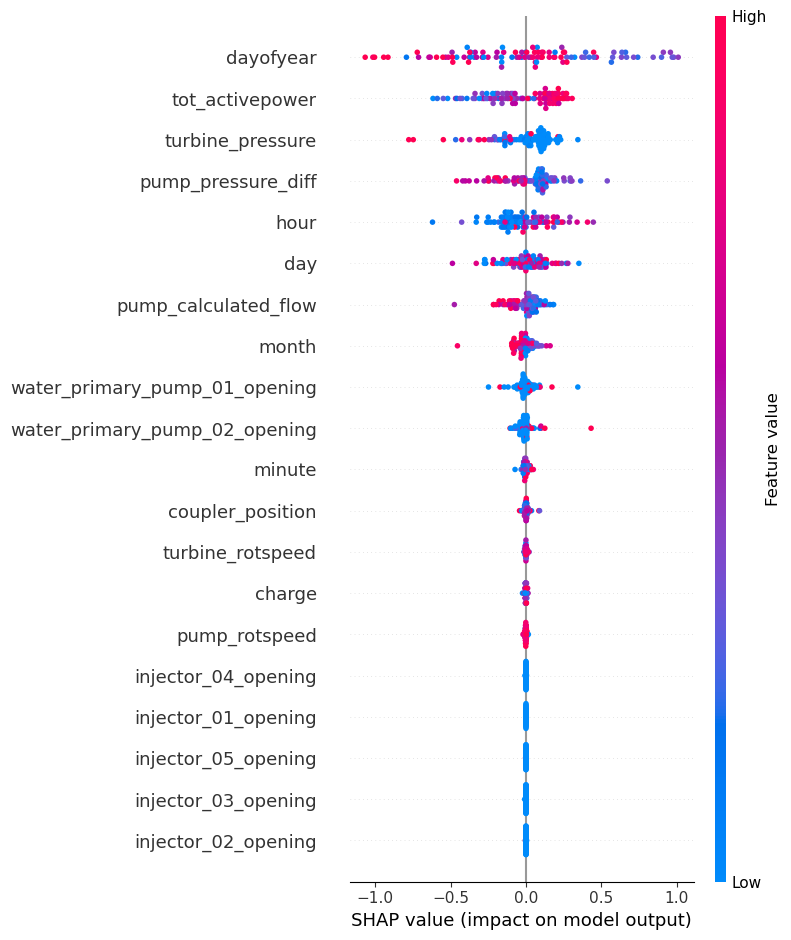

In [ ]:
# Summary plot to visualize the impact of each feature
shap.summary_plot(shap_values, X_sample)

# Force plot for a single prediction (e.g., first instance)
shap.force_plot(explainer.expected_value, shap_values[0, :], X_sample.iloc[0, :])